In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from seriate import seriate
from scipy.spatial.distance import pdist

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df

def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df

def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df

def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
     
    return data

def group_by_molecule(df, groupby_columns):
    '''
    Aggregate detection values per metabolite and dataset
    '''
    
    data = df.pivot_table(index=groupby_columns,
                 values='detectability',
                 aggfunc='max').reset_index()
    return data

def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata

def summarise_per_class(df, groupby_columns):
    
    data = df.pivot_table(index=groupby_columns,
                      values=['detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    return data


def zero_fill_data(df, classification, class_col_name):
    
    # Do zero-filling using a pre-made template
    X = df['sample_name'].unique()
    Y = classification[class_col_name].unique()
    template = pd.DataFrame(product(X, Y), columns=['sample_name', class_col_name])
    data = template.merge(df, on=['sample_name', class_col_name], how='left').fillna(0)
    
    return data

def seriate_array(arr, direction='rows'):
    'This function returns the order of rows or columns in a seriated array '
    
    if direction == 'cols':
        arr = arr.T
    distances = pdist(arr)
    order = seriate(distances)
    return order

def plot_a_heatmap(data, title, figsize=(10,6)):
    
    fig,ax = plt.subplots(figsize=figsize)

    g = sns.heatmap(data=plot_data,
                    cmap='viridis',
                    cbar_kws={'label': 'Fraction Detected'},
                    ax=ax)

    g.set(title=title, xlabel="", ylabel="")
    plt.tight_layout()
    return g

- Inputs

In [3]:
p_root_dir = Path(ROOT_DIR)
p_data = p_root_dir / "data"
p_out = p_root_dir / "test"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / r"2022-08-16_All_Interlab_Predictions.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_18Jan2023.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

- Load data

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)
predictions.neutral_loss.fillna('', inplace=True)

# Get a subset of most relevant information from Datasets file
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'Participant lab', 'Technology', 'Interlab']] # 'Participant lab', 'Technology'
datasets_info['sample_name'] = datasets_info['Slide code'] + ': ' + datasets_info['Technology']

# Merge with predictions and classification
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only interlab datasets + EMBL datasets with 10ppm
df=df[df['Interlab']]

# Only consider data of detected ions
threshold=0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

In [5]:
# #duplicated due to unmergable data sets
# data = data[~data[['sample_name', 'name_short', 'adduct', 'neutral_loss']].duplicated()]

In [6]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

### Heatmap of metabolite detectabiliy per coarse class and technology

- Make a test plot

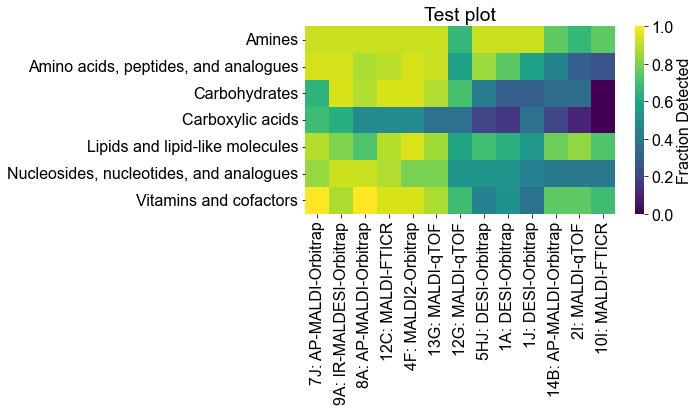

In [7]:
# Filter data
filtered_data = filter_data(data,
                            polarity='positive', 
                            neutral_losses=[''])

# Group detections by metabolite
molecule_data = group_by_molecule(filtered_data, 
                                 groupby_columns=['sample_name', 'name_short'])

# Map chemical classes
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Calculate detectability per class and technology
class_data = summarise_per_class(mapped_data,
                                 groupby_columns=['sample_name', 'main_coarse_class'])

# Zero fill data
zero_filled_data = zero_fill_data(class_data, chem_class, 'main_coarse_class')

# Pivot data for heatmap
plot_data = zero_filled_data.pivot_table(index = 'main_coarse_class',
                                       columns='sample_name',
                                       values='fraction_detected')

# Seriate data along OX axis
new_col_order = seriate_array(plot_data.to_numpy(), direction="cols")
plot_data = plot_data.reindex(columns=plot_data.columns[new_col_order])

# Plot
h = plot_a_heatmap(plot_data,
                  title="Test plot",
                  figsize=[10,6])
# h.figure.savefig(p_out / f"test.png")

- Batch-save plots in both ionisation modes

In [ ]:
for pol in ['positive', 'negative']:
    
    # Filter data
    filtered_data = filter_data(data,
                            polarity=pol, 
                            neutral_losses=[''])
    
    # Group detections by metabolite
    molecule_data = group_by_molecule(filtered_data, 
                                 groupby_columns=['sample_name', 'name_short'])
    

    # Map chemical classes
    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

    # Calculate detectability per class and technology
    class_data = summarise_per_class(mapped_data,
                                     groupby_columns=['sample_name', 'main_coarse_class'])

    # Zero fill data
    zero_filled_data = zero_fill_data(class_data, chem_class, 'main_coarse_class')

    # Pivot data for heatmap
    plot_data = zero_filled_data.pivot_table(index = 'main_coarse_class',
                                           columns='sample_name',
                                           values='fraction_detected')

    # Seriate data along OX axis
    new_col_order = seriate_array(plot_data.to_numpy(), direction="cols")
    plot_data = plot_data.reindex(columns=plot_data.columns[new_col_order])


    # Plot
    title = f"Metabolite detectability in {pol} ionisation mode"
    fname = f"Interlab_heatmap_{pol}"
    h = plot_a_heatmap(plot_data,title=title)
    h.figure.savefig(p_out / f"{fname}.png")
    h.figure.savefig(p_out / f"{fname}.pdf")
    plt.close()